<a href="https://colab.research.google.com/github/ShawnLiu119/Demand_Forcasting_TimeSeries/blob/main/DF_TimeSeries_statistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: mount to my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore')

**statsmodels.graphics.tsaplots**: Provides functions for plotting autocorrelation and partial autocorrelation functions.

**statsmodels.tsa.stattools**: Contains the Augmented Dickey-Fuller test function for stationarity testing.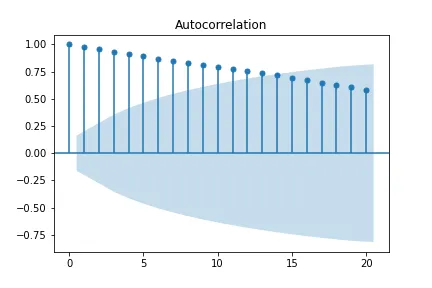

In [3]:
folder = "/content/drive/MyDrive/demand_forecasting"

In [4]:
#read data

train = pd.read_csv(os.path.join(folder, "train.csv"))
train.head()


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [6]:
train.store.value_counts()

store
1     91300
2     91300
3     91300
4     91300
5     91300
6     91300
7     91300
8     91300
9     91300
10    91300
Name: count, dtype: int64

In [7]:
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

print('Start: ', train['date'].min().date())
print('End: ', train['date'].max().date())

Start:  2013-01-01
End:  2017-12-31


In [8]:
train.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [9]:
def expand_df(df):
    data = df.copy()

    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek
    return data

train = expand_df(train)
train.head()

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5


# EDA

In [11]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum() #group by each specific date
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

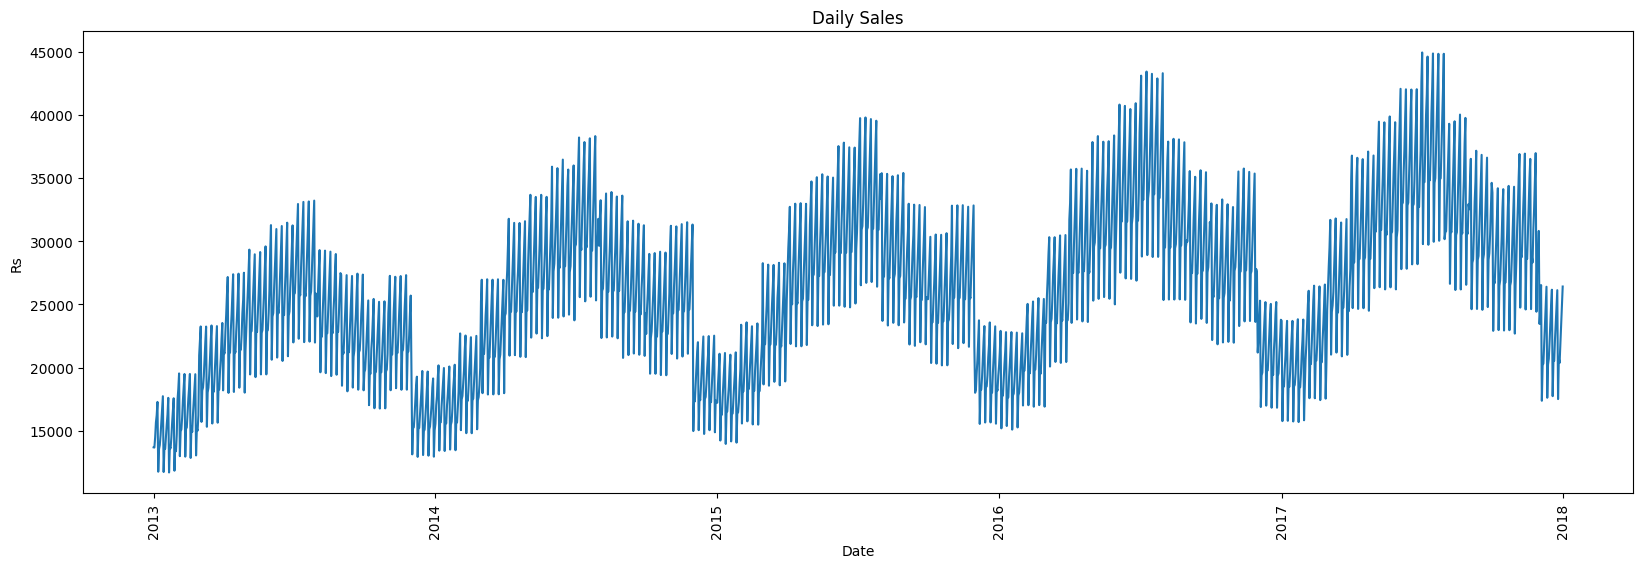

In [13]:
# prompt: change the figure size of above plot

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales')
plt.ylabel('Rs')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()


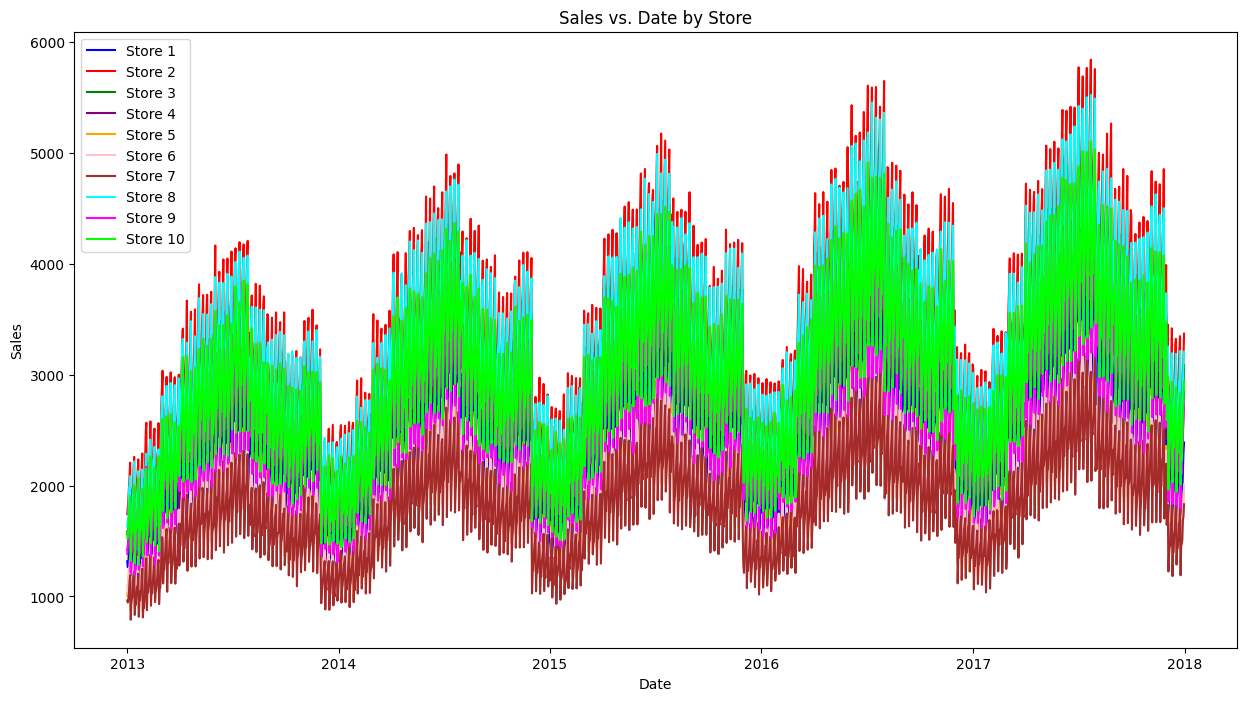

In [17]:
# prompt: change the figure size of plt.subplot
# time series data by store

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))

for store, color in store_colors.items():
    store_data = store_daily_sales[store_daily_sales['store'] == store]
    ax.plot(store_data['date'], store_data['sales'], label=f'Store {store}', color=color)

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales vs. Date by Store')
ax.legend()

# Show the plot
plt.show()


In [18]:
#
item_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()
day_sales = train.groupby(['day', 'date'], as_index=False)['sales'].sum()
month_sales = train.groupby(['month', 'date'], as_index=False)['sales'].sum()
year_sales = train.groupby(['year', 'date'], as_index=False)['sales'].sum()
day_of_week_sales = train.groupby(['dayofweek', 'date'], as_index=False)['sales'].sum()

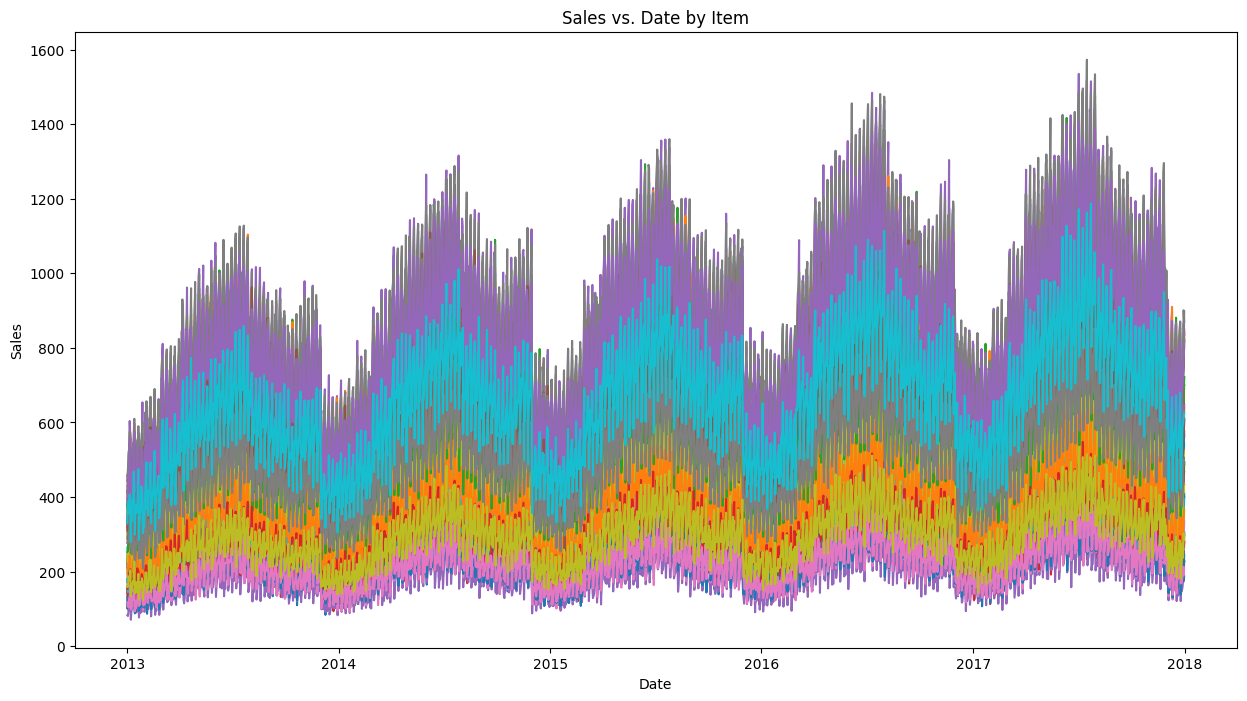

In [21]:
unique_items = item_sales['item'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Iterate through unique items and plot sales data for each item
for item in unique_items:
    item_data = item_sales[item_sales['item'] == item]
    ax.plot(item_data['date'], item_data['sales'], label=f'Item {item}')

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales vs. Date by Item')
# ax.legend()

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

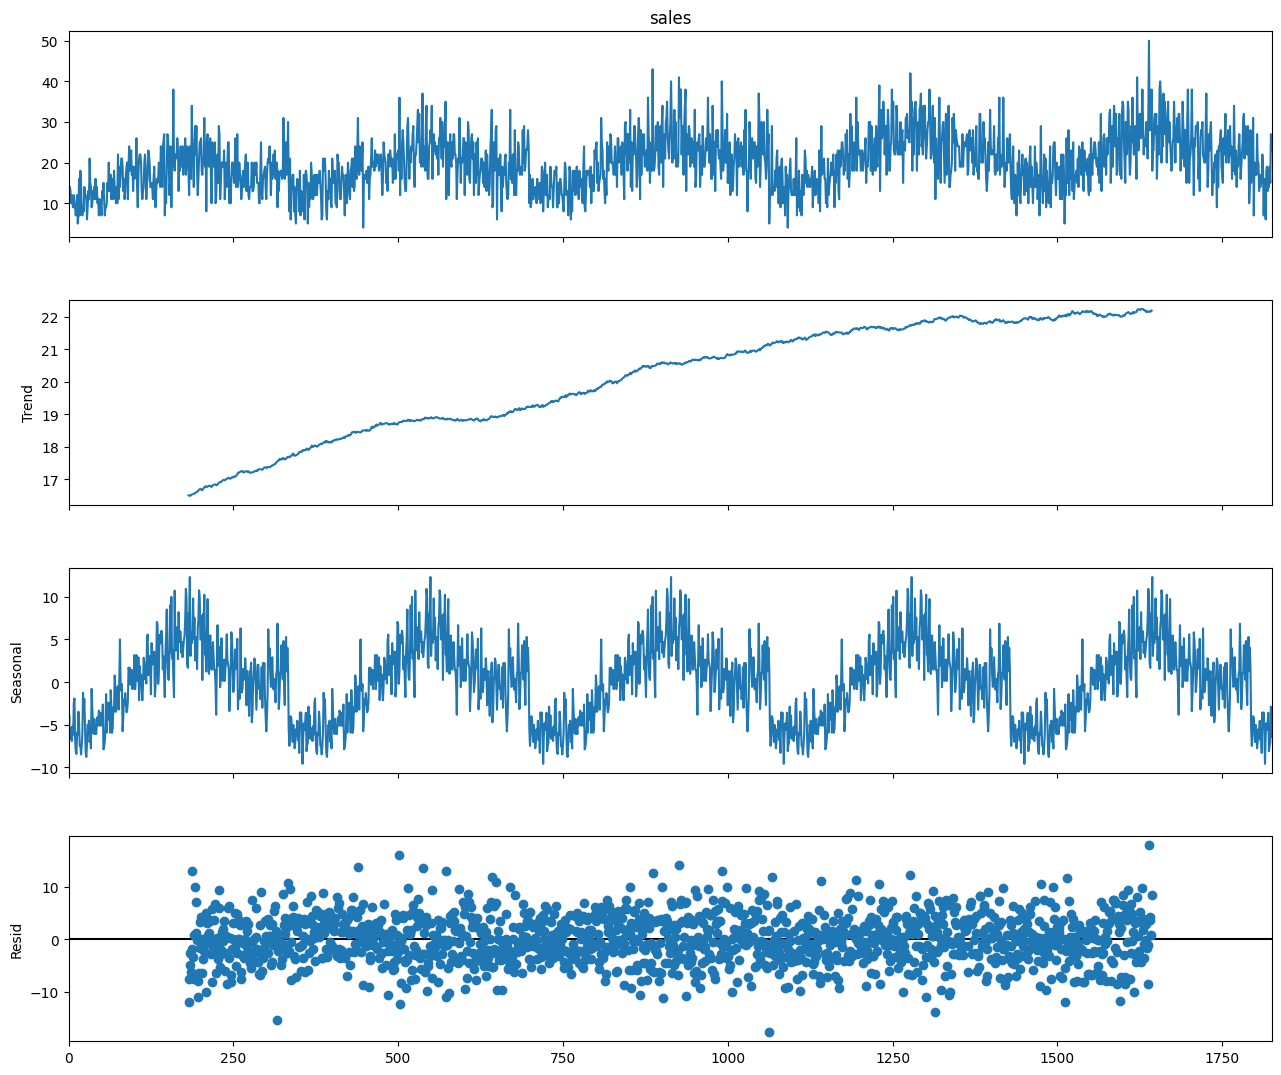

In [22]:
# only looking into the data into more narrow down (store==1, item==1)

train_i1_s1 = train[(train['store'] == 1) & (train['item'] == 1)]

#from statsmodels.tsa.seasonal import seasonal_decompose

result = sm.tsa.seasonal_decompose(train_i1_s1['sales'], model='additive', period=365) #Seasonal decomposition using moving averages
#additive --> type of seasonal component
#period ---> Period of the series (eg, 1 for annual, 4 for quarterly, etc), so 365 would be day

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)

#If you can identify a cause, you’ve found a deterministic trend.
#If you can’t identify a cause, it’s a stochastic (随机的，猜测的) trend.


reference:
https://www.kaggle.com/code/sumi25/understand-arima-and-tune-p-d-q

Why is this important? When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. **It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables.** So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

**Autocorrelation Function (ACF):**
Measures the correlation between a time series and its lagged values at different time lags.
Helps identify overall patterns of autocorrelation in the data.
**Peaks** in the ACF plot indicate significant autocorrelation at corresponding lags.

**Partial Autocorrelation Function (PACF):**
Measures the correlation between a time series and its lagged values after removing the effects of intervening lags.
Identifies the direct relationship between the current value and its past values without the influence of other lags.
**Significant spikes in the PACF plot suggest the order of the autoregressive (AR) component.**

In a stationary series, **the ACF values should decay quickly, indicating that there is little correlation between observations at different time lags**.

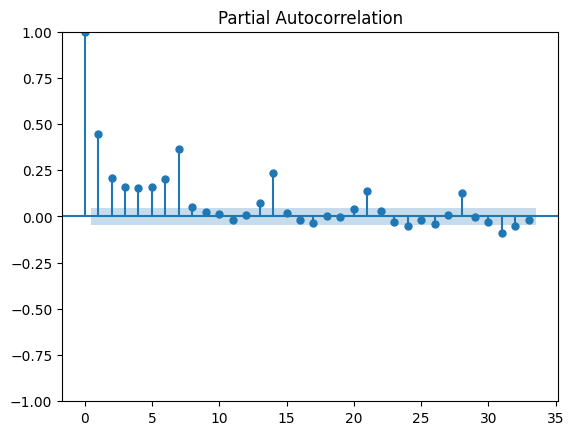

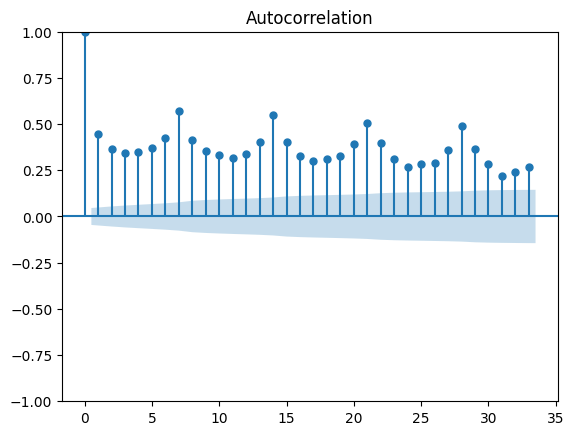

In [24]:
plot_pacf(train_i1_s1['sales']);
plot_acf(train_i1_s1['sales']);

Stationarity:
**Definition**: A time series is considered stationary if its statistical properties, such as mean and variance, remain constant over time.
**Importance**: Stationarity simplifies the modeling process by making statistical properties consistent. Many time series models, including ARIMA, assume stationarity for accurate predictions.
**Tests for Stationarity**: Augmented Dickey-Fuller (ADF) test is commonly used to test for stationarity. Stationary series show less dependence on past time steps, making forecasting more reliable.

 It tests the null hypothesis that a unit root is present in the series, which indicates non-stationarity. If the p-value obtained from the test is less than a certain threshold (e.g., 0.05), we can reject the null hypothesis and conclude that the series is stationary.

In [28]:
ad_fuller_result = adfuller(train_i1_s1['sales'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.1576705563328042
p-value: 0.02256938062657153


In [30]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

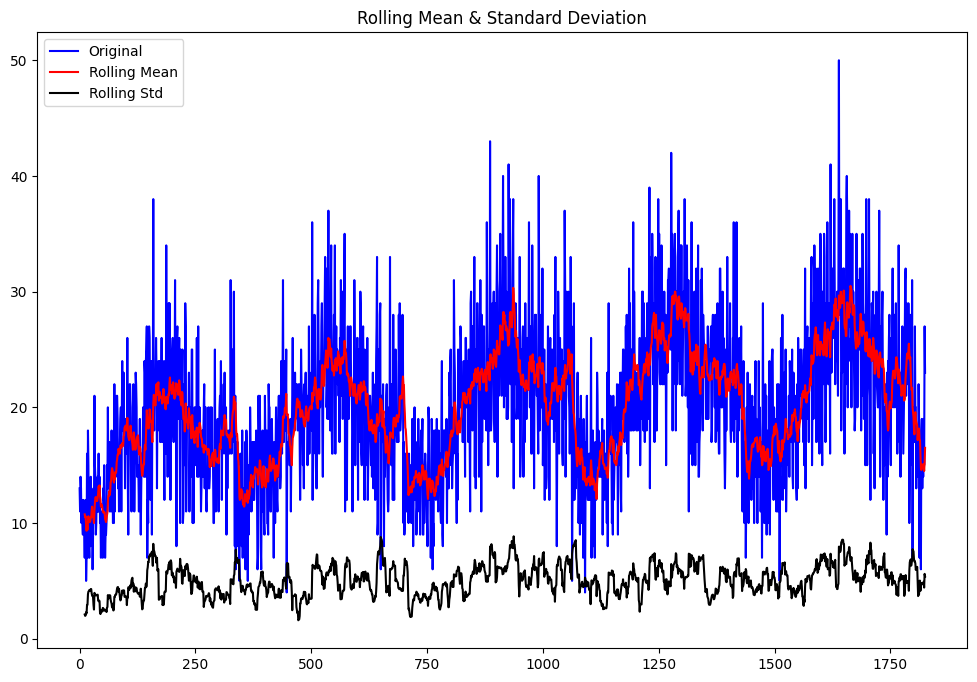

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [32]:
test_stationarity(train_i1_s1['sales'])